# Derive terrain attributes to be used for the equal sampling scheme

Want to extract for each length:
- slope
- upstream watershed area
- valley confinement

Start with the split length line string. Create a polygon from the line string by making a buffer above and below the line, clip a DEM to that polygon and compute the slope and valley confinement. Get usptream watershed area from the COMID and StreamCat

In [1]:
import geopandas as gpd
from shapely import box, MultiPoint, Point, LineString
import numpy as np
import matplotlib.pyplot as plt
import py3dep
import xrspatial

In [2]:
# load a gpd with geometry, parent_COMID, length
# see 'split.ipynb' for details on how to create that
segments = gpd.read_file("../data/segments_sample.shp")
segments = segments[['COMID', 'new_length', 'geometry']]
segments.columns = ['parent_COMID', 'length', 'geometry']
segments.head()

,parent_COMID,length,geometry
0,17682688,1000.000000,"LINESTRING (-199854.594 -99875.415, -199827.42..."
1,17682688,1000.000000,"LINESTRING (-199621.674 -100796.449, -199641.5..."
2,17682688,628.386352,"LINESTRING (-199436.146 -101676.162, -199466.9..."
3,17682372,527.909399,"LINESTRING (-199866.875 -99353.244, -199877.97..."
4,17682770,55.468423,"LINESTRING (-199753.786 -98689.097, -199755.45..."


In [36]:
# get bounding box,
# query 3dep for elevation and slope map of that bounding box
aoi = box(*segments.total_bounds)
dem = py3dep.get_map("DEM", aoi, resolution=10, geo_crs="epsg:3310", crs="epsg:4326")
dem = dem.rio.reproject(3310)
slope = xrspatial.slope(dem)
hillshade = xrspatial.hillshade(dem, angle_altitude=25, azimuth=225)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:23: RuntimeWarning:

invalid value encountered in sin

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:24: RuntimeWarning:

invalid value encountered in cos

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:25: RuntimeWarning:

invalid value encountered in cos



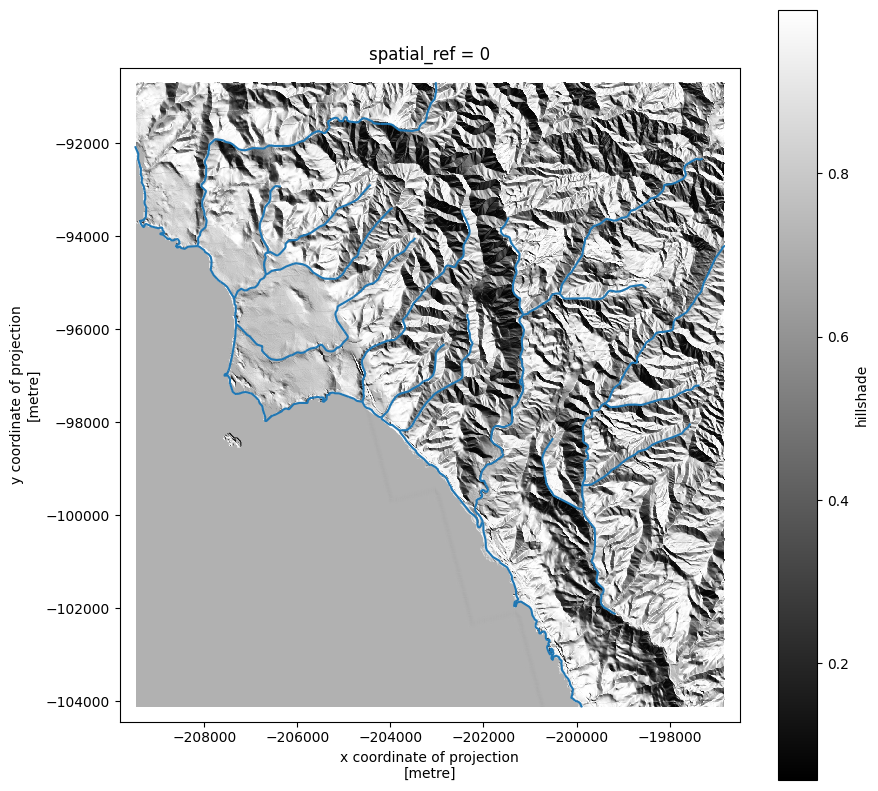

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
hillshade.plot(ax=ax, cmap='gray')
segments['geometry'].plot(ax=ax)
plt.show()

In [5]:
def get_nearest_vertices(point, linestring):
    line_coords = linestring.coords
    distances = [point.distance(Point(x, y)) for x, y in line_coords]
    nearest_indices = np.argsort(distances)[:2]
    nearest_vertices = [Point(line_coords[int(i)]) for i in nearest_indices]
    return nearest_vertices

def sample_point_on_perpendicular_line(point, A, B, alpha):
    length = A.distance(B)
    x = point.x + alpha * (A.y - B.y) / length
    y = point.y + alpha * (B.x - A.x) / length
    return Point(x,y)

def get_cross_section(point, linestring, width, alpha_increment, raster):
    A,B = get_nearest_vertices(point, linestring)
    npoints = width // alpha_increment
    positive_alphas = [alpha_increment * n for n in range(npoints+1)]
    negative_alphas = [-i for i in positive_alphas]
    alphas = negative_alphas + positive_alphas
    sample_points = [sample_point_on_perpendicular_line(point, A, B, alpha) for alpha in alphas]
    values = [raster.sel(x=point.x, y=point.y, method='nearest').values for point in sample_points]
    return (alphas,values)


def scan_to_threshold(point, linestring, alpha_increment, threshold, slope_map):
    A,B = get_nearest_vertices(point, linestring)
    alpha = 0
    slope = 0
    
    positive_results = []
    while slope < threshold:
        sp = sample_point_on_perpendicular_line(point, A, B, alpha)
        slope = slope_map.sel(x=sp.x, y=sp.y, method='nearest').values
        alpha = alpha + alpha_increment
        positive_results.append((sp, slope, alpha))
    
    alpha = 0
    slope = 0
    negative_results = []
    while slope < threshold:
        sp = sample_point_on_perpendicular_line(point, A, B, alpha)
        slope = slope_map.sel(x=sp.x, y=sp.y, method='nearest').values
        alpha = alpha - alpha_increment
        negative_results.append((sp, slope, alpha))
    
    return positive_results, negative_results


In [7]:
segment = segments['geometry'][5]
points = [segment.interpolate(i/10, normalized=True) for i in range(10)]
points

[<POINT (-199755.458 -98744.54)>,
 <POINT (-199770.243 -98799.166)>,
 <POINT (-199820.615 -98836.969)>,
 <POINT (-199829.885 -98900.982)>,
 <POINT (-199819.594 -98966.258)>,
 <POINT (-199818.22 -99032.12)>,
 <POINT (-199819.876 -99098.182)>,
 <POINT (-199821.532 -99164.244)>,
 <POINT (-199828.362 -99229.128)>,
 <POINT (-199855.452 -99289.403)>]

In [13]:
import pandas as pd
dfs = []
for i,point in enumerate(points):
    res = {}
    alphas, elevations = get_cross_section(point, segment, 1500, 20, dem)
    res['alpha'] = alphas
    res['elevations'] = elevations
    res['cross_section_index'] = i
    df = pd.DataFrame(res)
    dfs.append(df)
df = pd.concat(dfs)
df

,alpha,elevations,cross_section_index
0,0,53.896767,0
1,-20,53.85212,0
2,-40,55.593224,0
3,-60,58.07239,0
4,-80,63.013912,0
...,...,...,...
147,1420,352.87555,9
148,1440,358.5625,9
149,1460,357.3353,9
150,1480,354.3158,9


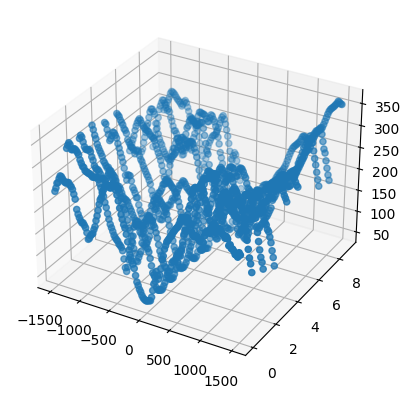

In [14]:
import pandas as pd
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=df['alpha'], ys=df['cross_section_index'], zs=df['elevations'])

In [17]:
import plotly.express as px

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='alpha', y='cross_section_index', z='elevations')

# Customize the plot (optional)
fig.update_layout(
    scene=dict(
        xaxis_title='Distance To Channel (meters)',
        yaxis_title='Cross Section Index',
        zaxis_title='Elevation (meters)',
        xaxis_range=[-1500, 1500],  # Set the range for the X-axis
        yaxis_range=[0, 9],  # Set the range for the Y-axis
        zaxis_range=[0, 1600]  # Set the range for the Z-axis
    ),
    title='3D Scatter Plot'
)

# Show the plot
fig.show()